In [9]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [10]:
!pip install -q SPARQLWrapper

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cellnet 0.1.0 requires merlin-core>=23.2, but you have merlin-core 0+untagged.1.gdf03015 which is incompatible.
cellnet 0.1.0 requires merlin-dataloader>=23.2, but you have merlin-dataloader 0+untagged.1.gbcd6dcf which is incompatible.
cellnet 0.1.0 requires pandas>=1.5, but you have pandas 1.3.5 which is incompatible.
cellnet 0.1.0 requires pyarrow>=10.0.0, but you have pyarrow 8.0.0 which is incompatible.
cellnet 0.1.0 requires setuptools>=62.1.0, but you have setuptools 45.2.0 which is incompatible.

[notice] A new release of pip is available: 23.1.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
# !pip install -q cellxgene-census
!pip install -q obonet


[notice] A new release of pip is available: 23.1.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
%load_ext autoreload

In [2]:
import pickle
import os
from os.path import join


import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
import dask.dataframe as dd
import lightning.pytorch as pl
import torch

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'
CKPT_PATH_TABNET = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default/w_augment_4/checkpoints/val_f1_macro_epoch=45_val_f1_macro=0.847.ckpt'

## Overview & download of non-10X data

### Overview non-10x data

In [ ]:
import cellxgene_census

In [62]:
COLUMN_NAMES = [
    "soma_joinid",
    "is_primary_data",
    "dataset_id", 
    "donor_id",
    "assay", 
    "cell_type", 
    "development_stage", 
    "disease", 
    "tissue", 
    "tissue_general"
]

#### Census release used in our paper

In [2]:
census = cellxgene_census.open_soma(census_version="2023-05-15")

In [3]:
summary = census["census_info"]['summary']

In [6]:
obs = (
    census["census_data"]["homo_sapiens"]
    .obs
    .read(
        column_names=COLUMN_NAMES,
        value_filter=f"is_primary_data == True"
    )
    .concat()
    .to_pandas()
)

In [7]:
obs['tech_sample'] = (obs.dataset_id + '_' + obs.donor_id).astype('category')

for col in COLUMN_NAMES:
    if obs[col].dtype == object:
        obs[col] = obs[col].astype('category')


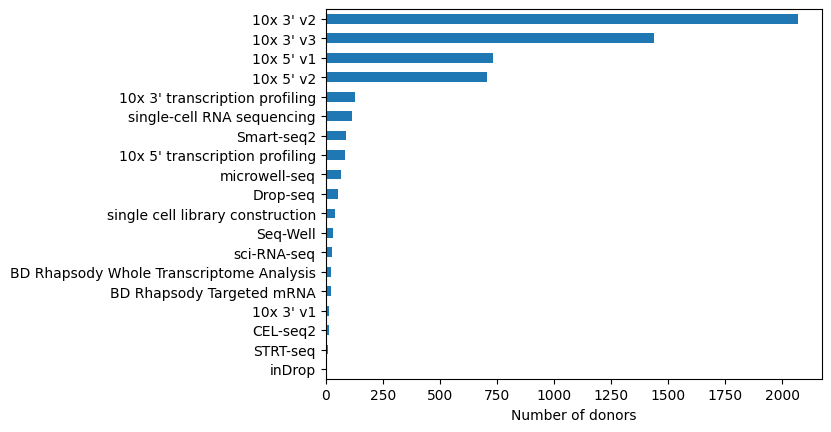

In [57]:
ax = (
    obs[['tech_sample', 'assay']].drop_duplicates()
    .groupby('assay')['tech_sample'].count()
    .sort_values(ascending=True)
    .plot.barh()
)
ax.set_ylabel('')
ax.set_xlabel('Number of donors');

#### Latest census release

In [59]:
census_latest = cellxgene_census.open_soma(census_version="2023-12-15")

In [60]:
summary_latest = census_latest["census_info"]['summary']

In [ ]:
obs_latest = (
    census_latest["census_data"]["homo_sapiens"]
    .obs
    .read(
        column_names=COLUMN_NAMES,
        value_filter=f"is_primary_data == True"
    )
    .concat().to_pandas()
)

In [66]:
obs_latest['tech_sample'] = (obs_latest.dataset_id + '_' + obs_latest.donor_id).astype('category')

for col in COLUMN_NAMES:
    if obs_latest[col].dtype == object:
        obs_latest[col] = obs_latest[col].astype('category')

In [74]:
protocols = [
    "10x 5' v2", 
    "10x 3' v3", 
    "10x 3' v2", 
    "10x 5' v1", 
    "10x 3' v1", 
    "10x 3' transcription profiling", 
    "10x 5' transcription profiling"
]

In [78]:
obs_latest[obs_latest.assay.isin(protocols)].tech_sample.nunique() - obs[obs.assay.isin(protocols)].tech_sample.nunique()

378

In [79]:
obs_latest[~obs_latest.assay.isin(protocols)].tech_sample.nunique() - obs[~obs.assay.isin(protocols)].tech_sample.nunique()

-48

### Download non-10x data

In [30]:
non_10x_protocols = [
    "Drop-seq",
    "Seq-Well",
    "Smart-seq2",
    "single-cell RNA sequencing",
    "BD Rhapsody Whole Transcriptome Analysis",
    "single cell library construction",
    "inDrop",
    "microwell-seq",
    "STRT-seq",
    "CEL-seq2",
    "BD Rhapsody Targeted mRNA"
]

obs_non_10x = (
    census["census_data"]["homo_sapiens"]
    .obs
    .read(
        column_names=COLUMN_NAMES,
        value_filter=f"is_primary_data == True and assay in {non_10x_protocols}"
    )
    .concat()
    .to_pandas()
)

In [33]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))

In [38]:
obs_non_10x = obs_non_10x[obs_non_10x.cell_type.isin(cell_type_mapping.label.tolist())]

In [49]:
gene_space_model = pd.read_parquet(join(DATA_PATH, 'var.parquet')).feature_id.tolist()

In [51]:
adata = cellxgene_census.get_anndata(
    census=census,
    organism="Homo sapiens",
    X_name='raw',
    obs_coords=obs_non_10x.soma_joinid.to_numpy(),
    var_value_filter=f"feature_id in {gene_space_model}",
    column_names={"obs": COLUMN_NAMES, "var": ['feature_id', 'feature_name']},
)
adata.write_h5ad('/mnt/dssfs02/cxg_census/h5ad_raw_2023_05_15_extended/non_10x.h5ad')

## Evalutate prediction quality on non 10x data

In [8]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))

In [9]:
import yaml

with open('shortend_cell_types.yaml', 'r') as f:
    shortend_cell_types = yaml.safe_load(f)

In [21]:
import scanpy as sc
from sklearn.metrics import classification_report

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier
from cellnet.utils.data_loading import dataloader_factory
from utils import correct_labels

In [11]:
adata_non_10x = sc.read_h5ad('/mnt/dssfs02/cxg_census/h5ad_raw_2023_05_15_extended/non_10x.h5ad')
# subset to cell types which are known to the model
adata_non_10x = adata_non_10x[adata_non_10x.obs.cell_type.isin(cell_type_mapping.label)].copy()
adata_non_10x.obs['cell_type_str'] = adata_non_10x.obs.cell_type.copy()
# convert to integer cell type representation
adata_non_10x.obs.cell_type = pd.Categorical(
    adata_non_10x.obs.cell_type, 
    cell_type_mapping.label.tolist(), 
    ordered=False
)
adata_non_10x

AnnData object with n_obs × n_vars = 839539 × 19331
    obs: 'soma_joinid', 'is_primary_data', 'dataset_id', 'donor_id', 'assay', 'cell_type', 'development_stage', 'disease', 'tissue', 'tissue_general', 'cell_type_str'
    var: 'feature_id', 'feature_name'

In [14]:
estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=2048)
estim.model = TabnetClassifier.load_from_checkpoint(CKPT_PATH_TABNET, **estim.get_fixed_model_params('tabnet'))
estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
probas = estim.predict(dataloader_factory(adata_non_10x.X, obs=adata_non_10x.obs[['cell_type']]))
y_pred = np.argmax(probas, axis=1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/usr/local/lib/python3.8/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 410/410 [02:04<00:00,  3.31it/s]


In [16]:
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))

In [19]:
y_true = adata_non_10x.obs.cell_type.cat.codes.to_numpy()
assert y_pred.shape[0] == y_true.shape[0]
y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)

In [22]:
reports = {}

for assay in adata_non_10x.obs.assay.unique():
    y_true_ = y_true[(adata_non_10x.obs.assay == assay).to_numpy()]
    y_pred_ = y_pred_corr[(adata_non_10x.obs.assay == assay).to_numpy()]
    
    reports[assay] = pd.DataFrame(classification_report(
        y_true_, y_pred_, labels=np.unique(y_true_), output_dict=True, zero_division=0.
    )).T


In [23]:
f1_scores = {'cell_type': [], 'f1-score': [], 'assay': []}

for k in np.unique(y_true):
    for assay, report in reports.items():
        if str(k) in report.index:
            f1_scores['cell_type'].append(cell_type_mapping.label.to_dict()[k])
            f1_scores['f1-score'].append(report.loc[str(k), 'f1-score'])
            f1_scores['assay'].append(assay)

f1_scores = pd.DataFrame(f1_scores).assign(
    cell_type_short=lambda df: df.cell_type.replace(shortend_cell_types)
)

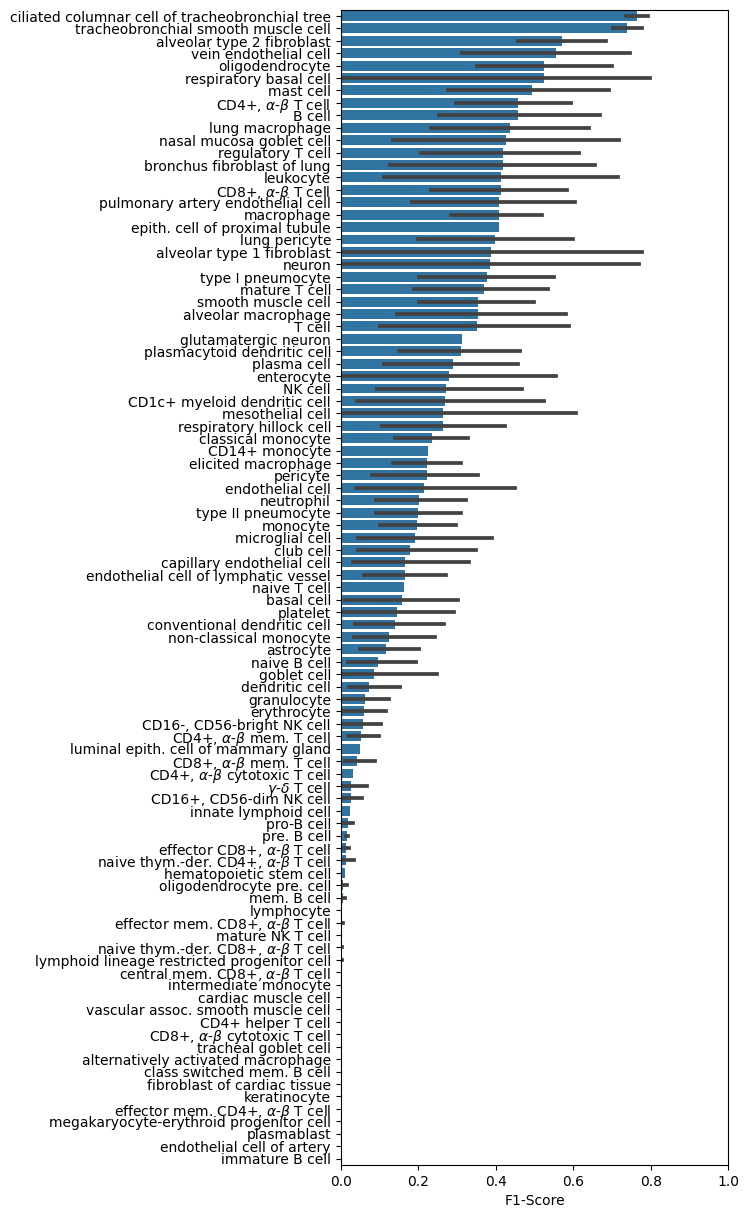

In [24]:
plt.rcParams['figure.figsize'] = (5, 15)

ax = sns.barplot(
    f1_scores,
    x='f1-score',
    y='cell_type_short',
    order=f1_scores.groupby('cell_type_short')['f1-score'].mean().sort_values(ascending=False).index.tolist(),
    color='#1f77b4'
)
ax.set_xlim(0., 1.)
ax.set_xlabel('F1-Score')
ax.set_ylabel('');

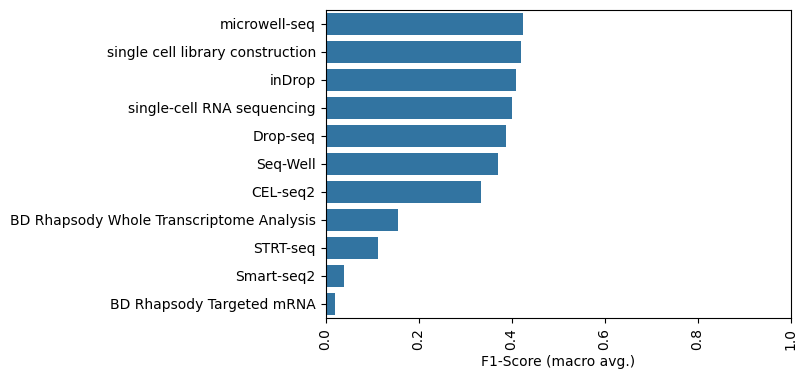

In [25]:
plt.rcParams['figure.figsize'] = (6, 4)

ax = sns.barplot(
    f1_scores.groupby('assay')['f1-score'].mean().sort_values(ascending=False).to_frame().reset_index(),
    x='f1-score', 
    y='assay',
    color='#1f77b4'
)

ax.set_xlim(0., 1.)
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylabel('')
ax.set_xlabel('F1-Score (macro avg.)');